
# Dog's Breed Identification

![Dogs](https://s.wsj.net/public/resources/images/B3-EU419_201908_GR_20190822110317.jpg)

* Generate dataset
* Build a model
* Predict

### Importing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as Imgen

from keras.models import Sequential,load_model
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,Dropout

from keras.preprocessing import image

import cv2

import pickle

**Reading the data and adding the extension to it.**

In [2]:
labels = pd.read_csv("../input/dog-breed-identification/labels.csv")
sample = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
def app_jpg(id):
    return id+".jpg"

In [4]:
labels['id'] = labels['id'].apply(app_jpg)
sample['id'] = sample['id'].apply(app_jpg)

**Data Generator**

In [6]:
datagen = Imgen(preprocessing_function=keras.applications.nasnet.preprocess_input,
                  shear_range=0.2,
                  zoom_range=0.2,
                  horizontal_flip=True,
                  validation_split=0.1
                 )

In [7]:
train_ds = datagen.flow_from_dataframe(
    labels,
    directory = '../input/dog-breed-identification/train', 
    x_col = 'id',
    y_col = 'breed',
    subset="training",
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
)


val_ds = datagen.flow_from_dataframe(
    labels,
    directory = '../input/dog-breed-identification/train',
    x_col = 'id',
    y_col = 'breed',
    subset="validation",
    color_mode="rgb",
    target_size = (331,331),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=123,
)

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


**Getting class names**

In [8]:
a = train_ds.class_indices
class_names = list(a.keys())
class_names[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

**Getting one batch of data to visualize**

In [9]:
x,y = next(train_ds)
x.shape

(32, 331, 331, 3)

**Function to plot images**

In [10]:
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

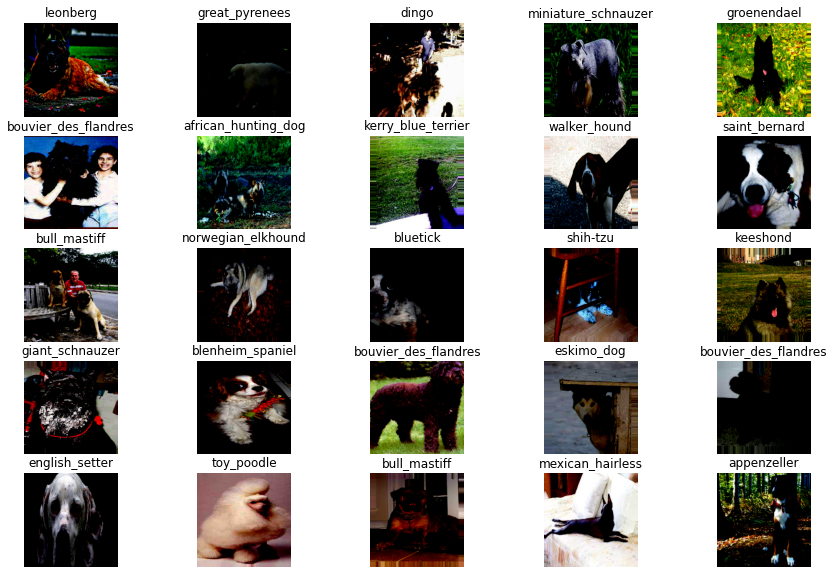

In [11]:
plot_images(x,y)

## Model

**Getting a Pre-Trained Model**

In [12]:
from keras.applications.nasnet import NASNetLarge

In [13]:
base_model = InceptionResNetV2(include_top=False,
                     weights='imagenet',
                     input_shape=(331,331,3)
                     )
base_model.trainable = False

219062272/219055592 [==============================] - 7s 0us/step


**Defining our Model**

In [14]:
model = Sequential([
    base_model,
    
    GlobalAveragePooling2D(),
    
    Dense(256,activation = 'relu'),
    Dropout(0.5),
    
    Dense(120,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 54,761,048
Trainable params: 424,312
Non-trainable params: 54,336,736
_________________________________________________________________


In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Defining callbacks to preserve the best results**

In [16]:
my_calls = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

### Train

In [17]:
hist = model.fit(train_ds,epochs=25,validation_data=val_ds,callbacks=my_calls)

Epoch 1/25
288/288 [==============================] - 311s 1s/step - loss: 2.5492 - accuracy: 0.5231 - val_loss: 0.3265 - val_accuracy: 0.9002

Epoch 00001: val_loss improved from inf to 0.32648, saving model to Model.h5
Epoch 2/25
288/288 [==============================] - 264s 916ms/step - loss: 0.4592 - accuracy: 0.8807 - val_loss: 0.3009 - val_accuracy: 0.9100

Epoch 00002: val_loss improved from 0.32648 to 0.30091, saving model to Model.h5
Epoch 3/25
288/288 [==============================] - 262s 908ms/step - loss: 0.3528 - accuracy: 0.8978 - val_loss: 0.2781 - val_accuracy: 0.9237

Epoch 00003: val_loss improved from 0.30091 to 0.27808, saving model to Model.h5
Epoch 4/25
288/288 [==============================] - 262s 909ms/step - loss: 0.3485 - accuracy: 0.8971 - val_loss: 0.3183 - val_accuracy: 0.9139

Epoch 00004: val_loss did not improve from 0.27808
Epoch 5/25
288/288 [==============================] - 262s 910ms/step - loss: 0.3174 - accuracy: 0.9070 - val_loss: 0.3100 - 

**Plotting the losses and acuuracies**

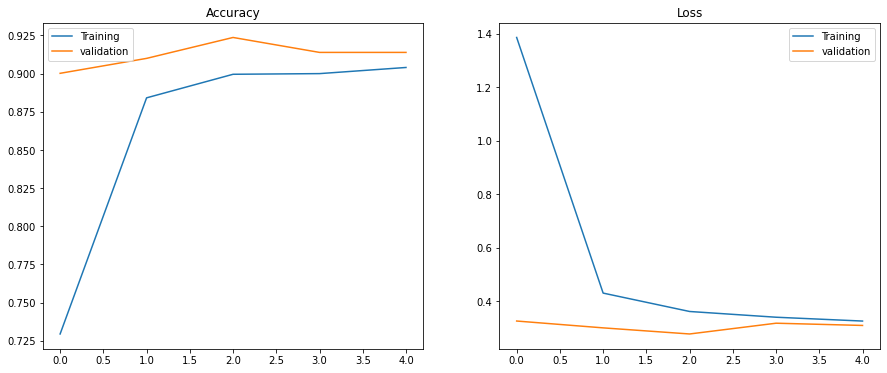

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


**Loading saved model**

In [19]:
model = load_model("./Model.h5")

## Prediction

**Genrating test dataset**

In [20]:
testgen = Imgen(preprocessing_function=keras.applications.inception_resnet_v2.preprocess_input)

In [21]:
test_ds = testgen.flow_from_dataframe(
    sample,
    directory = '../input/dog-breed-identification/test',
    x_col = 'id',
    y_col = None,
    target_size = (331,331),
    class_mode= None,
    batch_size=32,
    shuffle=False
)

Found 10357 validated image filenames.


**Making Predictions**

In [22]:
predictions = model.predict(test_ds,verbose=1)

324/324 [==============================] - 126s 379ms/step


- To get the most probable result

In [23]:
pred  = [np.argmax(i) for i in predictions]

In [24]:
X = next(test_ds)
X.shape

(32, 331, 331, 3)

**Visualizing images against predictions**

In [25]:
def check_images(img):
    plt.figure(figsize=[25,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[pred[i]])
        plt.axis('off')

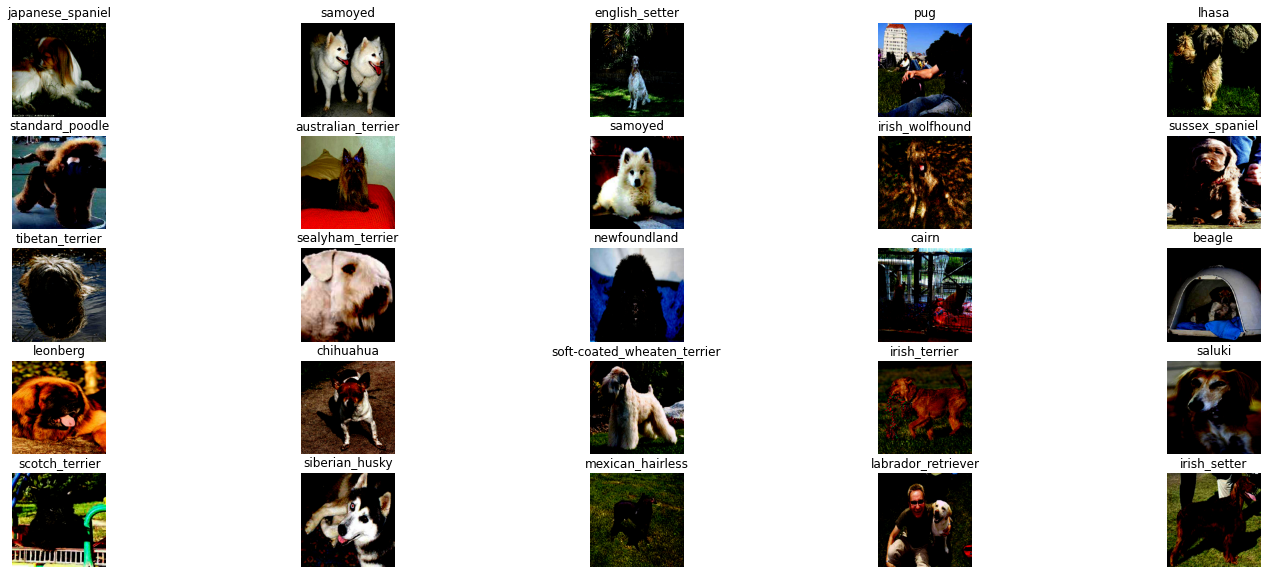

In [26]:
check_images(X)